# Data Transformation
There are a few things we can do to the data from the EDA notebook to make it easier to cluster. In this notebook, we will explore the following options:
- Smoothing out the data
- Subtracting market adjustments and industry adjustments from returns
- Replacing time series by lower dimensional data to make clustering easier
- Preparing data for clustering

We first make a function that takes some pictures from the EDA notebook, that can help us streamline visualizing what various smoothings and transformations do to the data

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

import pickle

In [15]:
closing_prices = pd.read_pickle("./data/stocks/closing_prices.pkl")
tickers = closing_prices.columns
with open('./models/industry_clusters.pkl', 'rb') as handle:
    industry_clusters = pickle.load(handle)
    
# creating a multi-index to group the tickers by industry
closing_prices.columns = pd.MultiIndex.from_arrays((closing_prices.columns.map(industry_clusters),
                                                    closing_prices.columns),
                                                    names=['Industry', 'Ticker'])

ROR = closing_prices.pct_change().dropna()

# Preparing some industry groupings
industry_cols = {ind : [col for col in tickers if industry_clusters[col] == ind] 
                        for ind in set(industry_clusters.values())}
MaterialsCols = industry_cols['Materials']
HealthCols = industry_cols['Health Care']

In [3]:
from data_processing.preprocessing import correlation_histogram

def explore(df, cluster = 'Health Care'):
    print(df.info())
    industry_averages = df.groupby(level=0, axis=1).mean()
    f, axarr = plt.subplots(2,2, figsize = (10,8))
    
    df[cluster].plot(legend = False, ax = axarr[0][0])
    axarr[0][0].set_title(f"plotting cluster: {cluster}")
    axarr[0][0].set_xticklabels([])
    axarr[0][0].set_xlabel('')
    
    sns.histplot(df[cluster], legend = False, ax = axarr[0][1], bins = 40)
    axarr[0][1].set_title(f"values histogram for: {cluster}")
    
    industry_averages.plot(legend = False, ax = axarr[1][0])
    axarr[1][0].set_title("Plotting industry averages")
    
    correlation_histogram(df, bins = 20, clusters = industry_clusters, ax = axarr[1][1])
    axarr[1][1].set_title("Correlation histogram coloured by cluster")
    
    f.suptitle("Some information about the data")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2022-11-01 00:00:00-04:00 to 2023-10-30 00:00:00-04:00
Columns: 498 entries, ('Industrials', 'MMM') to ('Health Care', 'ZTS')
dtypes: float64(498)
memory usage: 974.6 KB
None


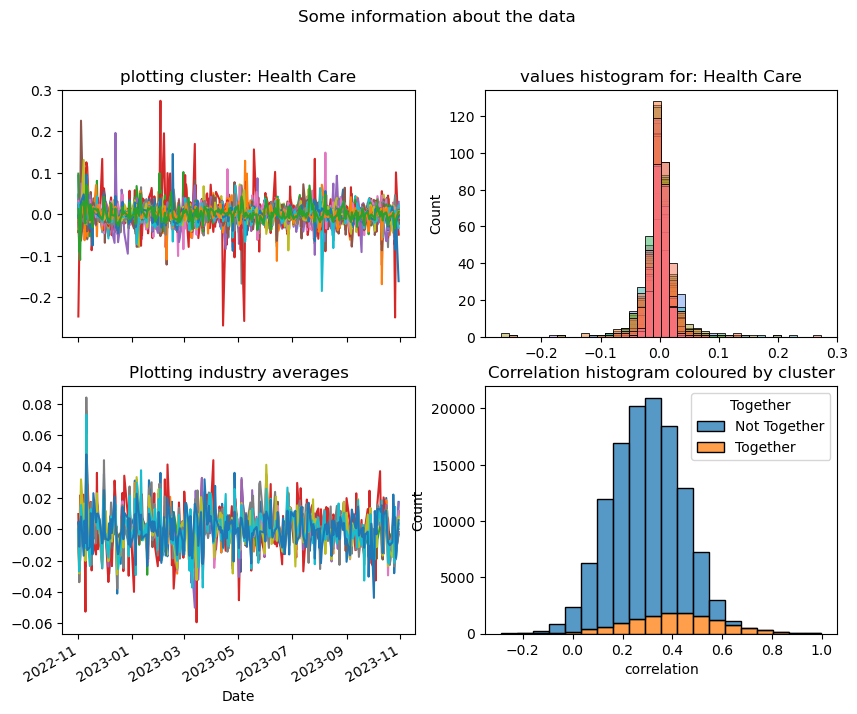

In [4]:
explore(ROR)

# Smoothing Returns
One possible transformation of the data is to smooth out the daily returns. This has the effect of making our analysis less sensitive to shocks, although it removes from the interpretability of the time series. Nevertheless, we examine what it does.

To smooth, we use two parameters: the window size, $k$, and the decay term, $0 < \alpha \le 1$. We then preform the following operation:
$$
\hat r_{n+k} = \frac{1}{\sum_{i=0}^{k-1} \alpha^i} \sum_{i=1}^{i = k} r_{n+k-i}\alpha^i
$$

The idea is to use ARMA-type moving averages to take a weighted sum of the returns, placing a large weight on the most recent one. Note that when $\alpha = 1$, this is just a rolling average.

<AxesSubplot:xlabel='Date'>

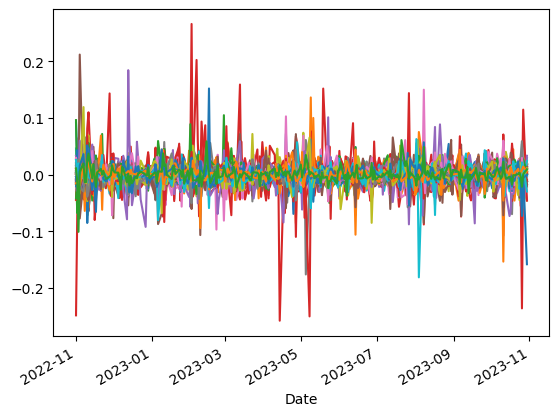

In [5]:
HC_industry_adj = ROR['Health Care'].sub(ROR['Health Care'].mean(axis = 1), axis = 0)
HC_industry_adj.plot(legend = False)

In [6]:
HC_smooth = HC_industry_adj.ewm(alpha = 0.5, adjust = True, axis = 0).mean()

#HC_smooth = HC_industry_adj.rolling(20).mean().dropna()

<AxesSubplot:xlabel='Date'>

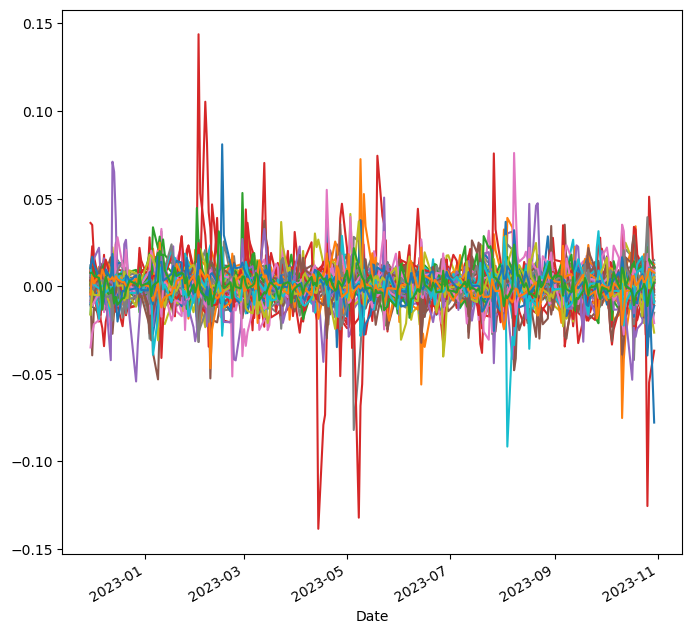

In [7]:
f, ax = plt.subplots(figsize = (8,8))

HC_smooth[20:].dropna().plot(legend = False, ax = ax)

Text(0.5, 1.0, 'values histogram for smoothed data')

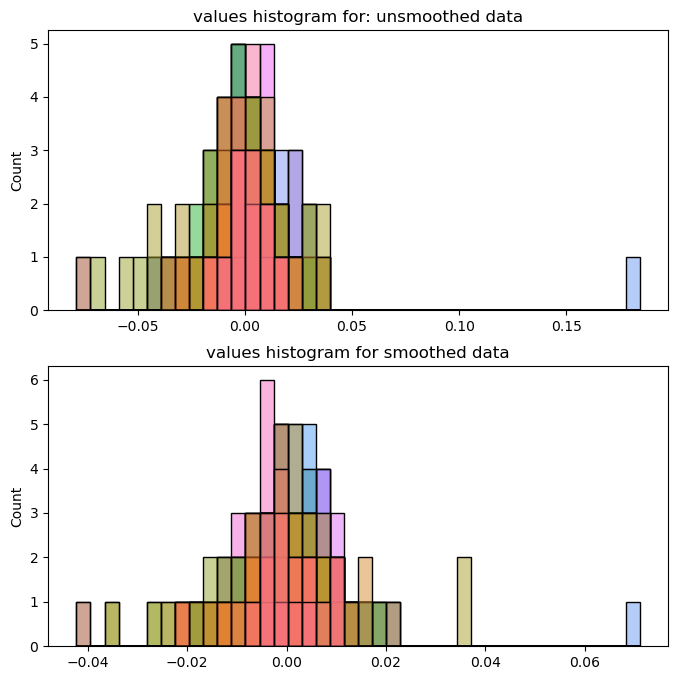

In [8]:
f, axarr = plt.subplots(2, 1, figsize = (8,8), sharex = False)

sns.histplot(HC_industry_adj[20:30], legend = False, ax = axarr[0], bins = 40)
axarr[0].set_title(f"values histogram for: unsmoothed data")

sns.histplot(HC_smooth[20:30], legend = False, ax = axarr[1], bins = 40)
axarr[1].set_title(f"values histogram for smoothed data")

In [9]:
from data_processing.preprocessing import market_adjust
from data_processing.preprocessing import industry_adjust

In [ ]:
adjusted_ROR = industry_adjust(market_adjust(ROR))

In [13]:
closing_prices

Industry                  Industrials            Health Care              \
Ticker                            MMM        AOS         ABT        ABBV   
Date                                                                       
2022-10-31 00:00:00-04:00  119.091064  54.044529   96.999535  140.715378   
2022-11-01 00:00:00-04:00  118.627167  53.866943   97.362274  141.205582   
2022-11-02 00:00:00-04:00  116.317108  52.979031   96.117180  138.908371   
2022-11-03 00:00:00-04:00  116.307640  53.640030   94.558372  138.812241   
2022-11-04 00:00:00-04:00  118.191650  55.228413   96.146599  139.638870   
...                               ...        ...         ...         ...   
2023-10-24 00:00:00-04:00   90.120003  66.639999   94.809998  146.309998   
2023-10-25 00:00:00-04:00   89.389999  65.190002   93.570000  145.259995   
2023-10-26 00:00:00-04:00   88.650002  69.120003   93.980003  145.199997   
2023-10-27 00:00:00-04:00   87.519997  67.809998   92.849998  138.929993   
2023-10-30 00:00:00-04:00   89.519997  69.489998   93.000000  141.889999   

Industry                  Information Technology Consumer Staples  \
Ticker                                       ACN              ADM   
Date                                                                
2022-10-31 00:00:00-04:00             279.459991        94.968796   
2022-11-01 00:00:00-04:00             277.067993        95.507393   
2022-11-02 00:00:00-04:00             268.189056        93.813271   
2022-11-03 00:00:00-04:00             252.862579        94.283310   
2022-11-04 00:00:00-04:00             257.075592        93.215919   
...                                          ...              ...   
2023-10-24 00:00:00-04:00             296.089996        69.470001   
2023-10-25 00:00:00-04:00             292.679993        71.050003   
2023-10-26 00:00:00-04:00             292.040009        71.849998   
2023-10-27 00:00:00-04:00             290.040009        70.040001   
2023-10-30 00:00:00-04:00             292.700012        71.419998   

Industry                  Information Technology Industrials  Utilities  \
Ticker                                      ADBE         ADP        AES   
Date                                                                      
2022-10-31 00:00:00-04:00             318.500000  236.614792  25.615273   
2022-11-01 00:00:00-04:00             316.019989  238.513962  25.791525   
2022-11-02 00:00:00-04:00             301.220001  232.444397  25.292147   
2022-11-03 00:00:00-04:00             285.929993  231.132614  25.644648   
2022-11-04 00:00:00-04:00             285.750000  231.876617  25.909025   
...                                          ...         ...        ...   
2023-10-24 00:00:00-04:00             539.559998  240.449997  14.530000   
2023-10-25 00:00:00-04:00             521.140015  218.330002  14.680000   
2023-10-26 00:00:00-04:00             514.280029  218.839996  14.900000   
2023-10-27 00:00:00-04:00             508.119995  214.839996  14.750000   
2023-10-30 00:00:00-04:00             526.940002  216.080002  14.950000   

Industry                  Financials  ...             Industrials  \
Ticker                           AFL  ...         WTW         GWW   
Date                                  ...                           
2022-10-31 00:00:00-04:00  63.578457  ...  215.037827  578.000854   
2022-11-01 00:00:00-04:00  65.238472  ...  217.984344  586.260132   
2022-11-02 00:00:00-04:00  65.121300  ...  216.929901  577.634888   
2022-11-03 00:00:00-04:00  64.418236  ...  214.791443  587.941711   
2022-11-04 00:00:00-04:00  65.599770  ...  217.994202  587.189941   
...                              ...  ...         ...         ...   
2023-10-24 00:00:00-04:00  77.760002  ...  207.889999  686.710022   
2023-10-25 00:00:00-04:00  78.260002  ...  207.740005  677.409973   
2023-10-26 00:00:00-04:00  77.519997  ...  229.080002  699.669983   
2023-10-27 00:00:00-04:00  76.489998  ...  228.919998  706.760010   
2023-10-30 00:00:00-

In [8]:
ROR = closing_prices[::1].pct_change().dropna()

<AxesSubplot:xlabel='Date'>

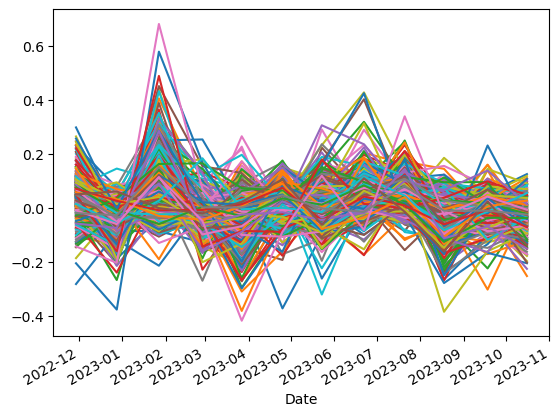

In [11]:
ROR.plot(legend = False)

In [17]:
list(industry_cols.keys())

['Industrials',
 'Financials',
 'Real Estate',
 'Energy',
 'Information Technology',
 'Communication Services',
 'Consumer Staples',
 'Utilities',
 'Health Care',
 'Consumer Discretionary',
 'Materials']

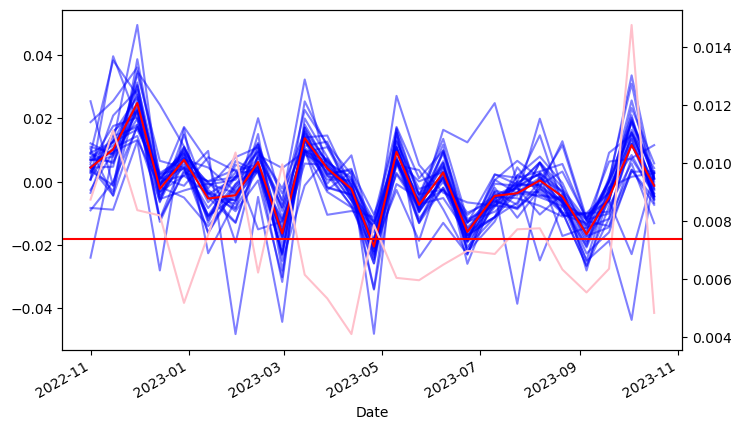

In [39]:
f, ax  = plt.subplots(1, 1, figsize = (8,5))

ROR['Utilities'][::10].plot(legend = False, ax = ax, color = 'blue', alpha = 0.5)
ROR['Utilities'][::10].mean(axis = 1).plot(legend = False, ax = ax, color = 'red')

p1 = ROR['Utilities'][::10].std(axis = 1).plot(legend = False, ax = ax, color = 'pink', secondary_y=True, label = 'STD')
mean_std = ROR['Utilities'][::10].std(axis = 1).mean()
p1.axhline(y = mean_std, color = 'red')
